# PROGRAMMING LANGUAGE DETECTOR (PLD)
### - BY NAZRI BAJURI

## METHOD 1: NATURAL LANGUAGE PROCESSING (NLP

In [1]:
import logging
import re
from typing import Counter
import numpy as np
import os
from gensim.models import Word2Vec
from keras import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from keras.models import model_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from numpy import asarray, zeros
import pickle

from src import config
from src.config import input_length

all_languages = ["Python", "C", "Java", "Scala", "Javascript", "CSS", "C#", "HTML"]


#### DATA BASE  - CONSTRUCT VOCAB ########
def load_words_from_string(s):
    contents = " ".join(s.splitlines())
    result = re.split(r"[{}()\[\]\'\":.*\s,#=_/\\><;?\-|+]", contents)

    # remove empty elements
    result = [word for word in result if word.strip() != ""]

    return result

#### BUILD VOCAN TOKENIZER ######

def save_vocab_tokenizer(vocab_tokenzier_location, vocab_tokenizer):
    with open(vocab_tokenzier_location, 'wb') as f:
        pickle.dump(vocab_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)


def load_vocab_tokenizer(vocab_tokenizer_location):
    with open(vocab_tokenizer_location, 'rb') as f:
        tokenizer = pickle.load(f)
    return tokenizer


def evaluate_saved_data(x_file_name, y_file_name, model):
    x = np.loadtxt(x_file_name)
    y = np.loadtxt(y_file_name)
    loss, accuracy = model.evaluate(x, y, verbose=2)
    print(f"loss: {loss}, accuracy: {accuracy}")


def to_binary_list(i, count):
    result = [0] * count
    result[i] = 1
    return result


def get_lang_sequence(lang):
    for i in range(len(all_languages)):
        if all_languages[i] == lang:
            return to_binary_list(i, len(all_languages))
    raise Exception(f"Language {lang} is not supported.")


def encode_sentence(sentence, vocab_tokenizer):
    encoded_sentence = vocab_tokenizer.texts_to_sequences(sentence.split())
    return [word[0] for word in encoded_sentence if len(word) != 0]


def load_vocab(vocab_location):
    with open(vocab_location) as f:
        words = f.read().splitlines()
    return set(words)


##### BUILD WORD VECTORS  #####


def load_word2vec(word2vec_location):
    result = dict()
    with open(word2vec_location, "r", encoding="utf-8") as f:
        lines = f.readlines()[1:]
    for line in lines:
        parts = line.split()
        result[parts[0]] = asarray(parts[1:], dtype="float32")
    return result


def load_model(model_file_location, weights_file_location):
    with open(model_file_location) as f:
        model = model_from_json(f.read())
    model.load_weights(weights_file_location)
    return model


def build_vocab_tokenizer_from_set(vocab):
    vocab_tokenizer = Tokenizer(lower=False, filters="")
    vocab_tokenizer.fit_on_texts(vocab)
    return vocab_tokenizer


def get_files(data_dir):
    result = []
    depth = 0
    for root, sub_folders, files in os.walk(data_dir):
        depth += 1

        # ignore the first loop
        if depth == 1:
            continue

        language = os.path.basename(root)
        result.extend([os.path.join(root, f) for f in files])
        depth += 1
    return result


def load_words_from_file(file_name):
    try:
        with open(file_name, "r") as f:
            contents = f.read()
    except UnicodeDecodeError:
        logging.warning(f"Encountered UnicodeDecodeError, ignore file {file_name}.")
        return []
    return load_words_from_string(contents)


def get_languages(ext_lang_dict):
    languages = set()
    for ext, language in ext_lang_dict.items():
        if type(language) is str:
            languages.update([language])
        elif type(language) is list:
            languages.update(language)
    return languages


def save_model(model, model_file_location, weights_file_location):
    os.makedirs(os.path.dirname(model_file_location), exist_ok=True)
    with open(model_file_location, "w") as f:
        f.write(model.to_json())
    model.save_weights(weights_file_location)


def save_vocabulary(vocabulary, file_location):
    with open(file_location, "w+") as f:
        for word in vocabulary:
            f.write(word + "\n")


def is_in_vocab(word, vocab_tokenizer):
    return word in vocab_tokenizer.word_counts.keys()


def concatenate_qualified_words(words, vocab_tokenizer):
    return " ".join([word for word in words if is_in_vocab(word, vocab_tokenizer)])


def load_sentence_from_file(file_name, vocab_tokenizer):
    words = load_words_from_file(file_name)
    return concatenate_qualified_words(words, vocab_tokenizer)


def load_sentence_from_string(s, vocab_tokenizer):
    words = load_words_from_string(s)
    return concatenate_qualified_words(words, vocab_tokenizer)


def load_encoded_sentence_from_file(file_name, vocab_tokenizer):
    sentence = load_sentence_from_file(file_name, vocab_tokenizer)
    return encode_sentence(sentence, vocab_tokenizer)


def load_encoded_sentence_from_string(s, vocab_tokenizer):
    sentence = load_sentence_from_string(s, vocab_tokenizer)
    return encode_sentence(sentence, vocab_tokenizer)


def load_data(data_dir, vocab_tokenizer):
    files = get_files(data_dir)
    x = []
    y = []
    for f in files:
        language = os.path.dirname(f).split(os.path.sep)[-1]
        x.append(load_encoded_sentence_from_file(f, vocab_tokenizer))
        y.append(get_lang_sequence(language))
    return pad_sequences(x, maxlen=input_length), asarray(y)


def build_vocab(train_data_dir):
    vocabulary = Counter()
    files = get_files(train_data_dir)
    for f in files:
        words = load_words_from_file(f)
        vocabulary.update(words)

    # remove rare words
    min_count = 5
    vocabulary = [word for word, count in vocabulary.items() if count >= min_count]
    return vocabulary


def build_word2vec(train_data_dir, vocab_tokenizer):
    all_words = []
    files = get_files(train_data_dir)
    for f in files:
        words = load_words_from_file(f)
        all_words.append([word for word in words if is_in_vocab(word, vocab_tokenizer)])
    model = Word2Vec(all_words, size=100, window=5, workers=8, min_count=1)
    return {word: model[word] for word in model.wv.index2word}


def get_word2vec_dimension(word2vec):
    first_vector = list(word2vec.values())[0]
    return len(first_vector)


def build_weight_matrix(vocab_tokenizer, word2vec):
    vocab_size = len(vocab_tokenizer.word_index) + 1
    word2vec_dimension = get_word2vec_dimension(word2vec)
    weight_matrix = zeros((vocab_size, word2vec_dimension))
    for word, index in vocab_tokenizer.word_index.items():
        weight_matrix[index] = word2vec[word]
    return weight_matrix


 ##### MODEL DEVELOPMENT #######


def build_model(train_data_dir, vocab_tokenizer, word2vec):
    weight_matrix = build_weight_matrix(vocab_tokenizer, word2vec)

    # build the embedding layer
    input_dim = len(vocab_tokenizer.word_index) + 1
    output_dim = get_word2vec_dimension(word2vec)
    x_train, y_train = load_data(train_data_dir, vocab_tokenizer)

    embedding_layer = Embedding(input_dim, output_dim, weights=[weight_matrix], input_length=input_length,
                                trainable=False)
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(filters=128, kernel_size=5, activation="relu"))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(len(all_languages), activation="sigmoid"))
    logging.info(model.summary())
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=10, verbose=2)
    return model


def evaluate_model(test_data_dir, vocab_tokenizer, model):
    x_test, y_test = load_data(test_data_dir, vocab_tokenizer)
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    logging.info('Test Accuracy: %f' % (acc * 100))


def build_and_save_vocab_tokenizer(train_data_dir, vocab_tokenizer_location):
    vocab = build_vocab(train_data_dir)
    vocab_tokenizer = build_vocab_tokenizer_from_set(vocab)
    save_vocab_tokenizer(vocab_tokenizer_location, vocab_tokenizer)
    return vocab_tokenizer


if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO)

    vocab_tokenizer = build_and_save_vocab_tokenizer(config.train_data_dir, config.vocab_tokenizer_location)
    word2vec = build_word2vec(config.train_data_dir, vocab_tokenizer)

    model = build_model(config.train_data_dir, vocab_tokenizer, word2vec)
    evaluate_model(config.test_data_dir, vocab_tokenizer, model)

    save_model(model, config.model_file_location, config.weights_file_location)

Using TensorFlow backend.
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 29526 word types from a corpus of 3504159 raw words and 344 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:min_count=1 retains 29526 unique words (100% of original 29526, drops 0)
INFO:gensim.models.word2vec:min_count=1 leaves 3504159 word corpus (100% of original 3504159, drops 0)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 29526 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 50 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 3121990 word corpus (89.1% of prior 3504159)
INFO:gensim.models.base_any2vec:estimated required memory for 29526 words and 100 dimensions: 38383800 bytes
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.base_any2vec

INFO:gensim.models.base_any2vec:EPOCH - 5 : training on 3504159 raw words (247952 effective words) took 0.2s, 1237156 effective words/s
INFO:gensim.models.base_any2vec:training on a 17520795 raw words (1239759 effective words) took 1.5s, 832160 effective words/s
/Users/nazribajuri/anaconda3/envs/PLDetector/lib/python3.6/site-packages/ipykernel_launcher.py:204: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.
INFO:root:None


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          2952700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 496, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 248, 128)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 31744)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 126980    
Total params: 3,143,808
Trainable params: 191,108
Non-trainable params: 2,952,700
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/10
 - 2s - loss: 0.8025 - acc: 0.7057
Epoch 2/10
 - 1s - loss: 0.3905 - acc: 0.8299
Epoch 3/10
 - 1s - loss: 0.2232 - acc: 0.9273
Epoch 4/10
 - 1s - loss: 0.1288 - acc: 0.9549
Epoch 5/10
 - 1s - loss: 0.0791 - acc: 0.9753
Epoch 6/10
 - 1s - loss: 0.0511 - acc: 0.9847
Epoch 7/10
 - 1s - loss: 0.0406 - acc: 0.9862
Epoch 8/10
 - 1s - loss: 0.0341 - acc: 0.9876
Epoch 9/10
 - 1s - loss: 0.0289 - acc: 0.9884
Epoch 10/10
 - 1s - loss: 0.0256 - acc: 0.9898


INFO:root:Test Accuracy: 90.625000


In [6]:
### NEURAL NETWORK FOR DETECTION #####


import numpy as np
from keras.preprocessing.sequence import pad_sequences
from src import config
from src.config import input_length
from src.neural_network_trainer import load_model, \
    load_vocab_tokenizer, load_encoded_sentence_from_string, all_languages

vocab_tokenizer = load_vocab_tokenizer(config.vocab_tokenizer_location)
model = load_model(config.model_file_location, config.weights_file_location)


def to_language(binary_list):
    i = np.argmax(binary_list)
    return all_languages[i]


def get_neural_network_input(code):
    encoded_sentence = load_encoded_sentence_from_string(code, vocab_tokenizer)
    return pad_sequences([encoded_sentence], maxlen=input_length)


def detect(code):
    y_proba = model.predict(get_neural_network_input(code))
    return to_language(y_proba)

### Ask user to upload file which has the programming language to be identified

In [7]:
if __name__ == "__main__":
    code = input("Please copy and paste the language you want to identify: ")
    bold_start = '\033[1m'
    bold_end   = '\033[0m'
    
    print("The language type is:",bold_start, detect(code), bold_end)

Please copy and paste the language you want to identify: } /*  * Copyright (C) 2016 Jake Wharton  *  * Licensed under the Apache License, Version 2.0 (the "License");  * you may not use this file except in compliance with the License.  * You may obtain a copy of the License at  *  *      http://www.apache.org/licenses/LICENSE-2.0  *  * Unless required by applicable law or agreed to in writing, software  * distributed under the License is distributed on an "AS IS" BASIS,  * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  * See the License for the specific language governing permissions and  * limitations under the License.  */ package retrofit2.adapter.rxjava2;  import io.reactivex.Observable; import io.reactivex.Observer; import io.reactivex.disposables.Disposable; import io.reactivex.exceptions.CompositeException; import io.reactivex.exceptions.Exceptions; import io.reactivex.plugins.RxJavaPlugins; import retrofit2.Call; import retrofit2.Response;  final clas

The language type is:  Scala 


In [8]:
print("The language type is:",bold_start, detect(code), bold_end)

The language type is:  Scala 


## METHOD 2 - COMPUTER VISION 

Uses standard image classification models to classify images of source code.

## Setup

Set up Jupyter Notebook, import packages, set some constants.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from pathlib import Path

from fastai import *
from fastai.vision import *

In [4]:
PATH = 'data/renders/'

bs = 64
model_id = 'model-1'

tfms = []
size = 299


## Load data

In [5]:
def load_images():
    """ Loads images in PATH, sorting them into classes based on the subdirectory name.
    """
    p = Path(PATH)
    files = []
    classes = []
    for subdir in p.ls():
        for fn in subdir.glob('*.png'):
            files.append(fn)
            classes.append(subdir.name)

    return ImageDataBunch.from_lists(PATH, files, classes, ds_tfms=tfms, bs=bs, size=size)

data = load_images()


In [6]:
# Show the classes (categories)
print(len(data.classes), data.classes)


8 ['c', 'cpp', 'csharp', 'go', 'java', 'python', 'ruby', 'rust']


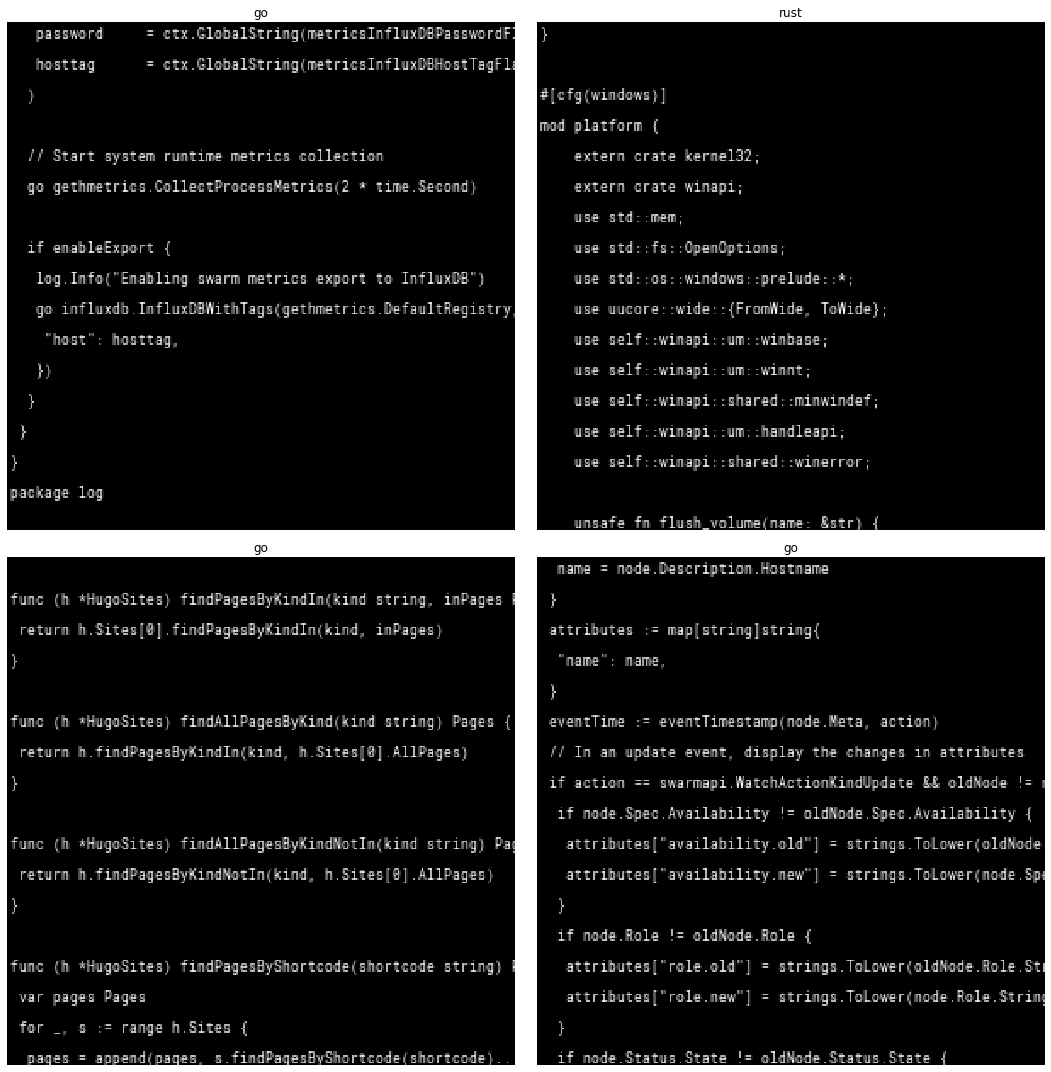

In [7]:
# Show some sample images
data.show_batch(rows=2, figsize=(15, 15))

## Model

Based on ResNet34.

In [8]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/Users/nazribajuri/anaconda3/envs/PLDetector/lib/python3.6/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


### Initial training

Only trains the final layer of the model.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


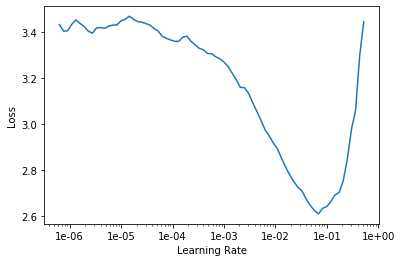

In [9]:
learn.lr_find()
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(6, 2e-2)

epoch,train_loss,valid_loss,error_rate,time
0,1.787380,2.838466,0.675000,33:34
1,1.238781,1.798833,0.458750,33:32
2,0.866475,1.123777,0.296250,32:43
3,0.577353,0.369541,0.123750,34:59
4,0.329011,0.358380,0.098750,31:25
5,0.196594,0.248726,0.072500,34:41


In [11]:
learn.save(f'{model_id}-stage-1')

### Unfreeze and train the full model

Train the full model (i.e. all layers) with smaller learning rates. This basically fine-tunes the earlier layers to better fit the new task it is given.

In [12]:
learn.load(f'{model_id}-stage-1')
learn.unfreeze()

In [15]:
learn.fit_one_cycle(4, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.022945,0.254392,0.065000,44:14
1,0.028367,0.291137,0.080000,43:35
2,0.021987,0.289390,0.068750,1:04:47
3,0.016122,0.273671,0.063750,43:27


In [16]:
learn.save(f'{model_id}-stage-2')

### Further training of the final layer

Freeze the model again and do further training of the final layer to get maximum accuracy.

In [17]:
learn.load(f'{model_id}-stage-2')
learn.freeze()

In [18]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.011097,0.286143,0.066250,35:08
1,0.012791,0.310588,0.068750,34:33
2,0.010021,0.281165,0.061250,33:44
3,0.006412,0.284454,0.066250,35:31


In [19]:
learn.save(f'{model_id}-stage-3')

## Explore the results

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

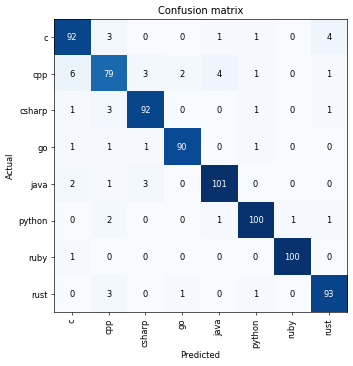

In [21]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

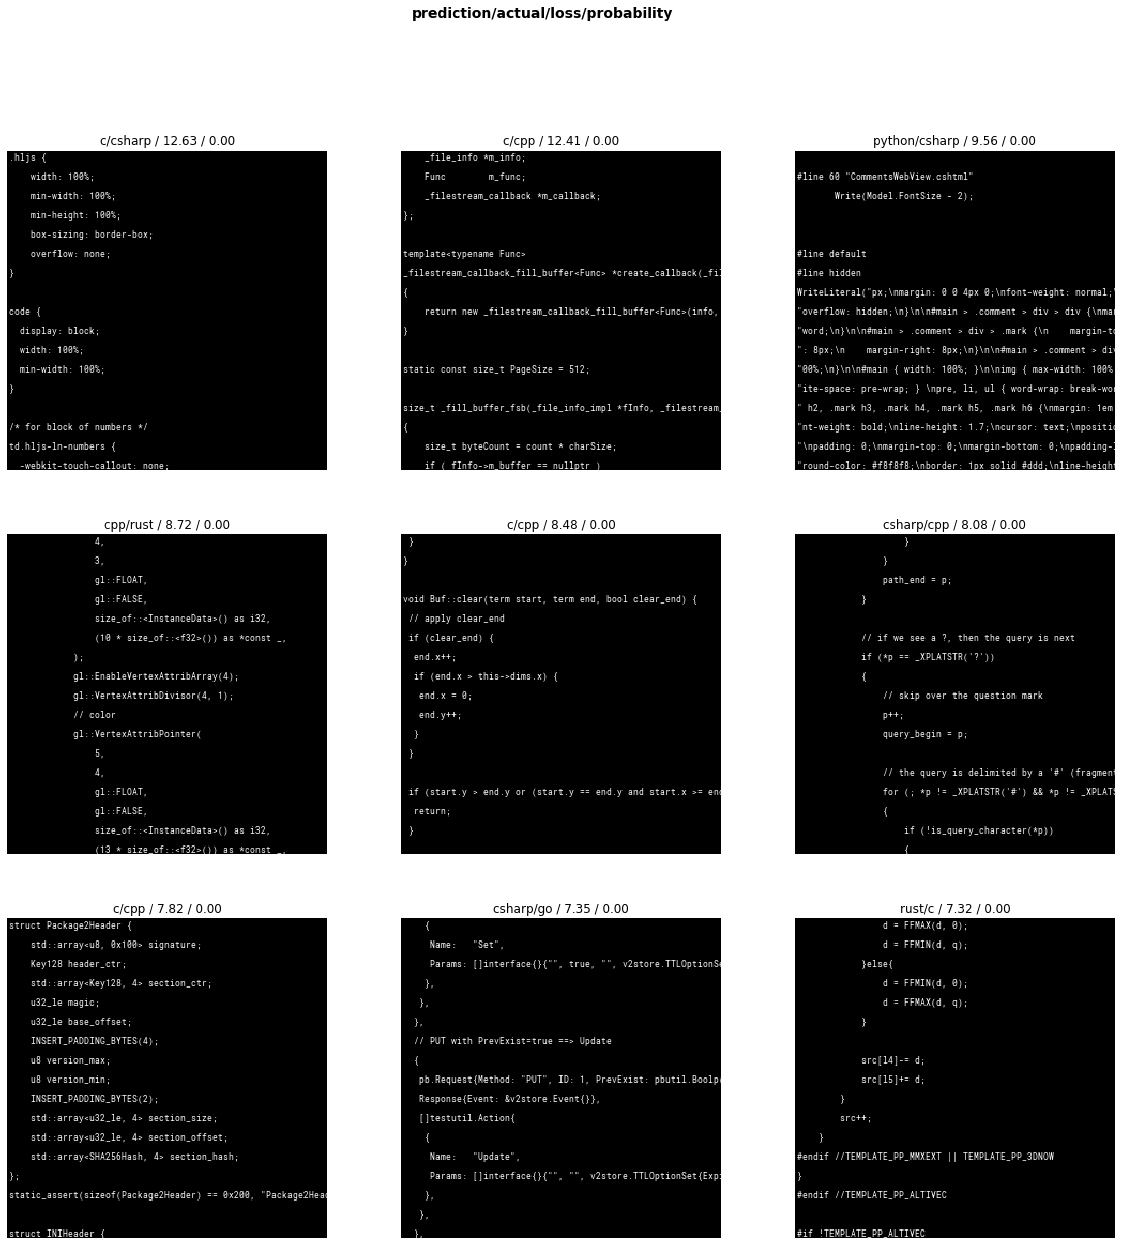

In [22]:
# Let's see the most incorrect predictions
interp.plot_top_losses(9, figsize=(20,20))

In [23]:
# Most confused categories, e.g. first line tells that C code was mistaken to be C++ quite often.
interp.most_confused()

[('cpp', 'c', 6),
 ('c', 'rust', 4),
 ('cpp', 'java', 4),
 ('c', 'cpp', 3),
 ('cpp', 'csharp', 3),
 ('csharp', 'cpp', 3),
 ('java', 'csharp', 3),
 ('rust', 'cpp', 3),
 ('cpp', 'go', 2),
 ('java', 'c', 2),
 ('python', 'cpp', 2),
 ('c', 'java', 1),
 ('c', 'python', 1),
 ('cpp', 'python', 1),
 ('cpp', 'rust', 1),
 ('csharp', 'c', 1),
 ('csharp', 'python', 1),
 ('csharp', 'rust', 1),
 ('go', 'c', 1),
 ('go', 'cpp', 1),
 ('go', 'csharp', 1),
 ('go', 'python', 1),
 ('java', 'cpp', 1),
 ('python', 'java', 1),
 ('python', 'ruby', 1),
 ('python', 'rust', 1),
 ('ruby', 'c', 1),
 ('rust', 'go', 1),
 ('rust', 'python', 1)]

TypeError: list indices must be integers or slices, not Category

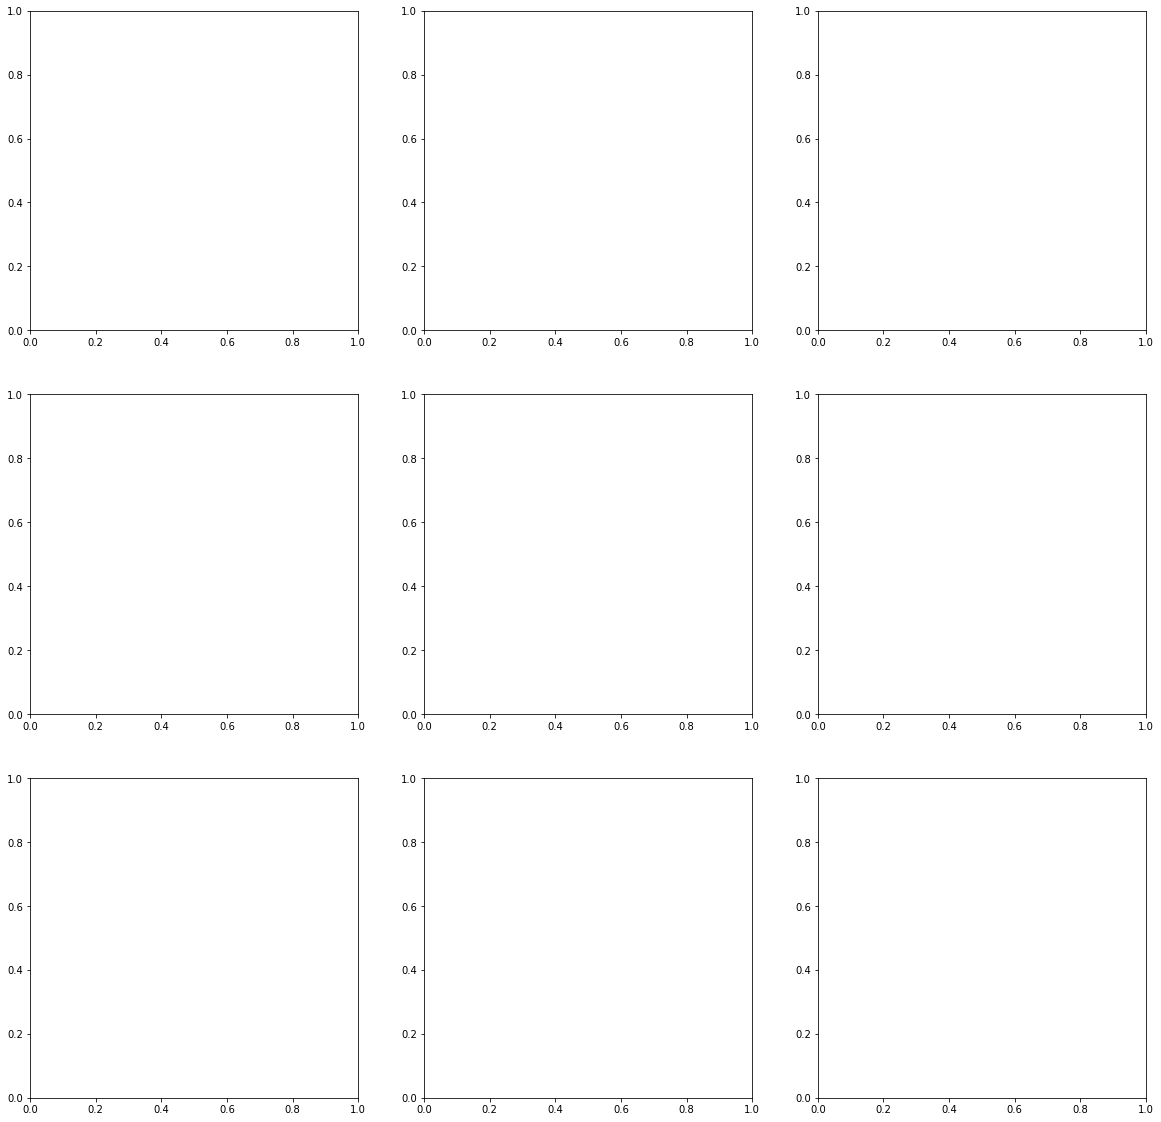

In [25]:
# Plot a few random predictions
def plot_random_predictions(interp, k, figsize=(12,12)):
    classes = interp.data.classes
    preds_count = len(interp.pred_class)
    sample_idxs = random.sample(range(preds_count), k)

    rows = math.ceil(math.sqrt(k))
    fig,axes = plt.subplots(rows,rows,figsize=figsize)
    #fig.suptitle('prediction/actual/loss/probability', weight='bold', size=14)
    
    for i, idx in enumerate(sample_idxs):
        t = interp.data.valid_ds[idx]
        title = f'{classes[interp.pred_class[idx]]}/{classes[t[1]]} / {interp.losses[idx]:.2f} / {interp.probs[idx][t[1]]:.2f}'
        t[0].show(ax=axes.flat[i], title=title)

plot_random_predictions(interp, 9, figsize=(20, 20))